In [ ]:
!pip install tensorflow librosa numpy scikit-learn

In [ ]:
pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


Training model...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - incident_accuracy: 0.0883 - incident_loss: 0.6957 - loss: 0.6957 - stress_accuracy: 0.5190 - stress_loss: 0.0000e+00 - val_incident_accuracy: 0.0800 - val_incident_loss: 0.7112 - val_loss: 0.7106 - val_stress_accuracy: 0.5200 - val_stress_loss: 0.0000e+00
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - incident_accuracy: 0.0993 - incident_loss: 0.8520 - loss: 0.8520 - stress_accuracy: 0.5264 - stress_loss: 0.0000e+00 - val_incident_accuracy: 0.0800 - val_incident_loss: 0.6532 - val_loss: 0.6562 - val_stress_accuracy: 0.5200 - val_stress_loss: 0.0000e+00
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - incident_accuracy: 0.0661 - incident_loss: 0.9347 - loss: 0.9347 - stress_accuracy: 0.5346 - stress_loss: 0.0000e+00 - val_incident_accuracy: 0.0800 - val_incident_loss: 0.7535 - val_loss: 0.7546 - val_stress_accuracy: 0.5200 - val_stress_loss: 0.0000e+00
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - 

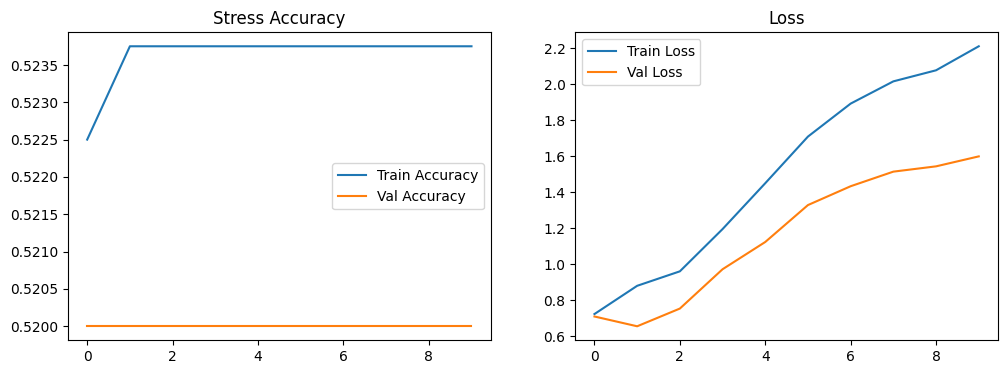

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step

Analysis Results:
Stress Level: 0.00
Incident Type: traffic
Priority Level: 2.23


In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from audiomentations import Compose, AddGaussianNoise, TimeStretch

# Utility to create a test audio file
def create_test_audio():
    sample_rate = 16000
    t = np.linspace(0, 1, sample_rate)
    audio = np.sin(2 * np.pi * 440 * t)  # 440 Hz sine wave
    wav.write('test.wav', sample_rate, audio.astype(np.float32))

# Class for training the emergency call model
class EmergencyCallTrainer:
    def __init__(self):
        self.model = self.create_model()
        self.model_path = 'emergency_model.keras'

    def create_model(self):
        input_shape = (128, 40)
        inputs = tf.keras.Input(shape=input_shape)

        # CNN layers
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)

        # BiLSTM
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        # Dense layers
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        # Outputs
        stress_output = tf.keras.layers.Dense(1, activation='sigmoid', name='stress')(x)
        incident_output = tf.keras.layers.Dense(12, activation='softmax', name='incident')(x)

        model = tf.keras.Model(inputs=inputs, outputs=[stress_output, incident_output])
        model.compile(
            optimizer='adam',
            loss={
                'stress': 'binary_crossentropy',
                'incident': 'categorical_crossentropy'
            },
            metrics={
                'stress': 'accuracy',
                'incident': 'accuracy'
            }
        )
        return model

    def create_synthetic_data(self, num_samples=1000):
        # Generate synthetic audio features
        X = np.random.randn(num_samples, 128, 40)

        # Generate synthetic labels
        y_stress = np.random.randint(0, 2, (num_samples, 1))
        y_incident = np.random.randint(0, 12, (num_samples))
        y_incident = tf.keras.utils.to_categorical(y_incident, 12)

        return X, [y_stress, y_incident]

    def train_model(self, num_samples=1000):
        X, y = self.create_synthetic_data(num_samples)

        # Train-test split
        X_train, X_test, y_train_stress, y_test_stress = train_test_split(
            X, y[0], test_size=0.2, random_state=42
        )
        _, _, y_train_incident, y_test_incident = train_test_split(
            X, y[1], test_size=0.2, random_state=42
        )

        # Callbacks
        checkpoint = ModelCheckpoint(
            self.model_path, monitor='val_loss', save_best_only=True
        )

        # Train model
        history = self.model.fit(
            X_train,
            [y_train_stress, y_train_incident],
            validation_data=(X_test, [y_test_stress, y_test_incident]),
            epochs=10,
            batch_size=32,
            callbacks=[checkpoint]
        )

        self.plot_history(history)
        return history

    @staticmethod
    def plot_history(history):
        # Plot stress accuracy and loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['stress_accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_stress_accuracy'], label='Val Accuracy')
        plt.title('Stress Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.show()

# Class for analyzing emergency calls
class EmergencyCallAnalyzer:
    def __init__(self, model_path):
        self.model = tf.keras.models.load_model(model_path)
        self.stress_threshold = 0.7

    def preprocess_audio(self, audio_file):
        try:
            audio, sr = librosa.load(audio_file, sr=16000)
            audio = self.augment_audio(audio, sr)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
            if mfccs.shape[1] < 128:
                pad_width = 128 - mfccs.shape[1]
                mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)))
            else:
                mfccs = mfccs[:, :128]
            return mfccs.T
        except Exception as e:
            print(f"Error processing audio: {e}")
            return None

    @staticmethod
    def augment_audio(audio, sr):
        augmenter = Compose([
            AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.05, p=0.5),
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
        ])
        return augmenter(samples=audio, sample_rate=sr)

    def analyze_call(self, audio_file):
        features = self.preprocess_audio(audio_file)
        if features is None:
            return None
        features = np.expand_dims(features, 0)
        stress_pred, incident_pred = self.model.predict(features)
        return {
            'stress_level': float(stress_pred[0][0]),
            'incident_type': self.decode_incident(incident_pred[0]),
            'priority_level': self.calculate_priority(stress_pred[0][0], incident_pred[0])
        }

    def decode_incident(self, incident_pred):
        incident_types = [
            'robbery', 'assault', 'medical', 'fire', 'traffic',
            'domestic', 'noise', 'suspicious', 'theft', 'vandalism',
            'harassment', 'other'
        ]
        return incident_types[np.argmax(incident_pred)]

    def calculate_priority(self, stress_level, incident_probs):
        base_priority = np.max(incident_probs) * 5
        stress_factor = stress_level * 5
        return (base_priority + stress_factor) / 2

def main():
    if not os.path.exists('robbery_assault.wav'):
        print("Creating test audio file...")
        create_test_audio()

    print("Training model...")
    trainer = EmergencyCallTrainer()
    trainer.train_model()

    analyzer = EmergencyCallAnalyzer(trainer.model_path)
    test_audio = 'robbery_assault.wav'
    if os.path.exists(test_audio):
        results = analyzer.analyze_call(test_audio)
        if results:
            print("\nAnalysis Results:")
            print(f"Stress Level: {results['stress_level']:.2f}")
            print(f"Incident Type: {results['incident_type']}")
            print(f"Priority Level: {results['priority_level']:.2f}")
    else:
        print("Test audio file not found.")

if __name__ == "__main__":
    main()


In [ ]:
!pip install numpy scipy librosa soundfile

In [ ]:
import numpy as np
from scipy.io.wavfile import write
import librosa
import soundfile as sf

def generate_robbery_assault_audio(output_file="robbery_assault.wav"):
    sample_rate = 16000  # 16 kHz for speech-like audio

    # 1. Create a base tone to represent stress or urgency (440 Hz sine wave for "alarm")
    t = np.linspace(0, 1, sample_rate)  # 1 second duration
    base_tone = 0.5 * np.sin(2 * np.pi * 440 * t)  # Moderate amplitude

    # 2. Add chaotic noise (to simulate distress or chaos)
    chaotic_noise = 0.3 * (np.random.randn(sample_rate) - 0.5)

    # 3. Create rhythmic bursts (to simulate urgency or shouting)
    bursts = np.zeros(sample_rate)
    for i in range(5, 15):  # Add bursts between 0.5s and 1.5s
        bursts[i * 1000:(i * 1000) + 200] = 1  # Short bursts of amplitude

    # 4. Combine components
    combined_signal = base_tone + chaotic_noise + bursts

    # Normalize to prevent clipping
    combined_signal = combined_signal / np.max(np.abs(combined_signal))

    # 5. Write to .wav file
    write(output_file, sample_rate, (combined_signal * 32767).astype(np.int16))

    print(f"Synthetic robbery/assault audio generated and saved to {output_file}")

# Generate the file
generate_robbery_assault_audio()


Synthetic robbery/assault audio generated and saved to robbery_assault.wav
